In [2]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import recordlinkage
from sklearn.feature_extraction.text import TfidfVectorizer
## nltk imports
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
# ! pip install xlrd
# ! pip install openpyxl
## lda 
from gensim import corpora
import gensim
import plotnine
from plotnine import *
## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## define constants and pathnames
GITHUB_DATA_PATH = "../data/"
DROPBOX_DATA_PATH = "../../../qss20_finalproj_rawdata/textasdata/"
MERGED_TEXT_JOBS_PKL = "../merged_addendums_jobdisclosures.pkl"
MERGED_TEXT_JOBS_CSV = "../merged_addendums_jobdisclosures.csv"


MERGED_TEXT_JOBS_PKL_DB = DROPBOX_DATA_PATH + "merged_addendums_jobdisclosures.pkl"

# Functions

In [3]:
## Text Processing
def processtext(row, colname, stopword_list,indicator, min_token_length = 4):
    
    ## get string form of listing
    string_of_col = str(row[colname]).lower()
    try:
        ## remove stopwords 
        remove_stop = [word for word in wordpunct_tokenize(string_of_col)
                      if word not in stopword_list]
        if indicator=="stem":
            processed_string = " ".join([porter.stem(i) 
                        for i in remove_stop if 
                        i.isalpha() and len(i) >= min_token_length])
        return(processed_string)
    except:
        processed_string = "" # to handle data errors where not actually text
        return(processed_string)


In [74]:
vectorizer = TfidfVectorizer()
def tfidf_topwords(df,label):
    tf_idf = vectorizer.fit_transform(df['text_preprocess'])
    top_words = pd.DataFrame(tf_idf.toarray(), columns=vectorizer.get_feature_names())
    stored=top_words.sum(axis=0).sort_values(ascending=False).head(10)
    plot=stored.plot.bar(title=label)
    plot.set_xlabel('Words')
    plot.set_ylabel('Tf-idf Score')
    fig = plot.get_figure()
#     fig.savefig("../output/" + label+".png")

In [75]:
#function to create table suitable for plotting LDA modeling's result
def df_onetopic(one_listoftup, i):
    words = [one_tup[0] for one_tup in one_listoftup]
    weights = [one_tup[1] for one_tup in one_listoftup]
    words_weights_df = pd.DataFrame({'words': words, 'weights': weights})
    words_weights_df['topic'] = "topic_" + str(i)
    return(words_weights_df)

In [76]:
## topic modeling
def topic_model(df):
    df = df[df.text_preprocess != ""].copy()
    tokenized_text = [wordpunct_tokenize(one_text) for one_text in 
                                      df.text_preprocess]
    text_proc_dict = corpora.Dictionary(tokenized_text)
    text_proc_dict.filter_extremes(no_below = round(df.shape[0]*0.02),
                             no_above = round(df.shape[0]*0.98))
    corpus_fromdict_proc = [text_proc_dict.doc2bow(one_text) 
                   for one_text in tokenized_text]
    ldamod = gensim.models.ldamodel.LdaModel(corpus_fromdict_proc, 
                                         num_topics = 3, id2word=text_proc_dict, 
                                         passes=6, alpha = 'auto',
                                        per_word_topics = True)
    topics_fromshow2 = [ldamod.show_topic(topicid = i, topn = 10) for i in [0, 1, 2]]
    return(topics_fromshow2)
    

# Load merged data from previous script

In [4]:
LOAD_LOCAL = True
if LOAD_LOCAL:
    merged_data = pd.read_pickle("../merged_addendums_jobdisclosures.pkl")
else:
    merged_data = pd.read_pickle(MERGED_TEXT_JOBS_PKL_DB)
    
merged_data.shape

# # test csv; same num rows so should be fine to load as alternative if needed
# merged_data_csv = pd.read_csv(DROPBOX_DATA_PATH + MERGED_TEXT_JOBS_CSV)
# # merged_data_csv.shape

(13127, 143)

# Preprocess text

In [5]:
RUN_WITH_SAMPLE = True
if RUN_WITH_SAMPLE:
    merged_data = merged_data.sample(n = 500)


In [6]:
work_pattern = r"[a-zA-Z]*work[a-zA-Z]*"
all_listings = "".join(merged_data.JOB_DESCRIPTION)
all_tokens = word_tokenize(all_listings)

all_matches_work = [one_word for one_word in all_tokens if 
                   re.match(work_pattern, one_word)]

other_stopwords = ["after", "before", "employer", "employ", "job", "although", "provide", "complete","hour","time",
                  "begin","list","require","transportation"]+ all_matches_work

list_stopwords = stopwords.words("english")

stopwords_complete = list_stopwords + other_stopwords
    
porter = PorterStemmer()


In [7]:

merged_data['text_preprocess'] = merged_data.apply(processtext,
                             axis = 1,
                             args = ["JOB_DESCRIPTION", stopwords_complete,"stem"])
merged_data.head()


,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,PHONE_TO_APPLY,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS,HOURLY_SCHEDULE_BEGIN,HOURLY_SCHEDULE_END,TRLA,JOB_DESCRIPTION,raw_text_length,text_preprocess
11322,H-300-20246-801059,Determination Issued - Certification,2020-09-10 11:30:01.310,2020-10-22 00:00:00.000,Individual Employer,N,Seasonal,N,Marvin Opp Farms,NaN,...,17013483562,NaN,www.jobsnd.com,1.0,8:00 AM,5:00 PM,False,Workers who qualify for inbound and/or outboun...,2907,qualifi inbound outbound travel reimburs entit...
4118,H-300-20062-367979,Determination Issued - Certification,2020-03-17 23:55:28.750,2020-03-26 00:00:00.000,Individual Employer,Y,Seasonal,N,Abel Tehandon Pineda,Tehandon Nursery,...,18285925016,tehandon-nursery@hotmail.com,www.ncworks.gov,2.0,NaN,NaN,False,Full Growing Season Commitment: The job offer...,3571,full grow season commit offer requir avail hou...
9559,H-300-19336-173635,Determination Issued - Certification,2019-12-10 16:03:34.870,2020-01-22 00:00:00.000,Individual Employer,N,Seasonal,N,Ag. Inc.,NaN,...,14766160930,flyaginc@gmail.com,NaN,0.0,NaN,NaN,False,Employer provided transportation will be airpl...,5568,provid airplan charter oper vehicl common mean...
10383,H-300-19309-128251,Determination Issued - Certification (Expired),2019-11-14 19:11:29.810000,2019-12-05 00:00:00.000000,Individual Employer,N,Seasonal,N,AB&T Zaunbrecher Farms,NaN,...,13375814092,a2zfamily@cox.net,NaN,2.0,NaN,NaN,True,"Deductions for FICA, federal or state tax with...",3824,deduct fica feder state withhold includ court ...
9461,H-300-19336-174643,Determination Issued - Certification,2019-12-09 15:39:25.630,2020-01-16 00:00:00.000,Individual Employer,N,Seasonal,N,Edward J Vincent Farms,NaN,...,13375238029,apv@kaplantel.net,laworks.net,1.0,NaN,NaN,True,"Time may vary due to mechanical, availability ...",76,vari mechan avail crop weather condit


In [8]:
## rj - above step takes awhile even on sample
## so writing; as a flag, this is with the sample

# merged_data.to_pickle(DROPBOX_DATA_PATH + "merged_addendums_preprocessed.pkl")

# Subset Merged_Data to TRLA and NonTRLA States

In [9]:
# TRLA
merged_TRLA=merged_data[merged_data.TRLA==True]
# NonTRLA
merged_nonTRLA=merged_data[merged_data.TRLA==False]

### Quick overview of number of job orders in that year range: all, TRLA, non-TRLA (post merging)


In [10]:
# case number all
merged_data.shape
# case number trla
merged_TRLA.shape
# case number trla
merged_nonTRLA.shape


(500, 144)

(118, 144)

(382, 144)

# Raw term frequency (Tf-Idf)

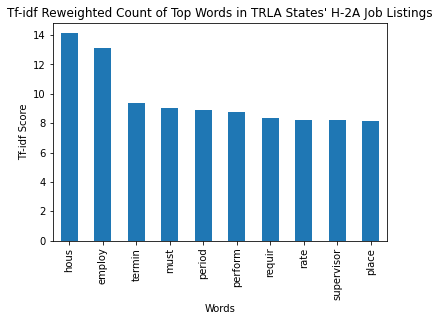

In [77]:
tfidf_topwords(merged_TRLA,"Tf-idf Reweighted Count of Top Words in TRLA States' H-2A Job Listings")

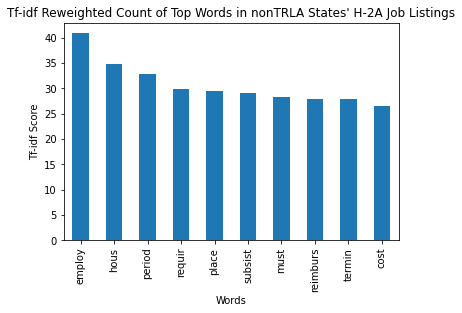

In [78]:
tfidf_topwords(merged_nonTRLA,"Tf-idf Reweighted Count of Top Words in nonTRLA States' H-2A Job Listings")

# Investigate the stemmed word "termin" in the original corpus

In [79]:

pd.set_option('display.max_colwidth', None)
termin=merged_data.loc[merged_data.JOB_DESCRIPTION.str.contains("termin"),
               "JOB_DESCRIPTION"].drop_duplicates().head(5)

# termin


# LDA Topic Modeling

### Find the Top Words and Topic

In [80]:
create table suitable for plotting LDA modeling's result
# def df_onetopic(one_listoftup, i):
#     words = [one_tup[0] for one_tup in one_listoftup]
#     weights = [one_tup[1] for one_tup in one_listoftup]
#     words_weights_df = pd.DataFrame({'words': words, 'weights': weights})
#     words_weights_df['topic'] = "topic_" + str(i)
#     return(words_weights_df)
topic_model(merged_TRLA)
topic_model(merged_nonTRLA)
topic_model(merged_data)



[[('hous', 0.023835478),
  ('employ', 0.012842826),
  ('provid', 0.012355685),
  ('must', 0.011337453),
  ('termin', 0.007858688),
  ('assign', 0.007141486),
  ('cost', 0.0069898074),
  ('plant', 0.00690775),
  ('prior', 0.0067139603),
  ('employe', 0.0066017588)],
 [('employ', 0.016103808),
  ('hous', 0.01317571),
  ('period', 0.012036119),
  ('requir', 0.010908584),
  ('must', 0.010643578),
  ('termin', 0.008899821),
  ('provid', 0.0083069485),
  ('crop', 0.0077368896),
  ('perform', 0.007426503),
  ('place', 0.007181091)],
 [('hous', 0.013400238),
  ('employ', 0.013390096),
  ('rate', 0.012973574),
  ('perform', 0.012550143),
  ('supervisor', 0.011853486),
  ('termin', 0.011599433),
  ('wage', 0.011256323),
  ('rule', 0.010706515),
  ('properti', 0.010553351),
  ('requir', 0.010460145)]]

[[('employ', 0.017906226),
  ('requir', 0.015091914),
  ('termin', 0.014796518),
  ('must', 0.013072221),
  ('period', 0.012789023),
  ('perform', 0.010680441),
  ('rate', 0.009966425),
  ('hour', 0.00862849),
  ('reason', 0.008492849),
  ('hous', 0.0084356805)],
 [('hous', 0.015319055),
  ('must', 0.0134849325),
  ('employ', 0.012970612),
  ('requir', 0.011056525),
  ('provid', 0.009714331),
  ('perform', 0.00859032),
  ('period', 0.0077618794),
  ('termin', 0.007179122),
  ('harvest', 0.006909821),
  ('field', 0.006005803)],
 [('employ', 0.018962888),
  ('hous', 0.018289294),
  ('period', 0.017303023),
  ('place', 0.016071292),
  ('subsist', 0.015298495),
  ('contract', 0.01408138),
  ('reimburs', 0.013826548),
  ('employe', 0.013690953),
  ('provid', 0.013574138),
  ('requir', 0.011685059)]]

[[('must', 0.014423915),
  ('hous', 0.01317703),
  ('employ', 0.011728385),
  ('termin', 0.010812773),
  ('requir', 0.00984716),
  ('period', 0.009586147),
  ('perform', 0.008502711),
  ('provid', 0.008272682),
  ('supervisor', 0.0081457095),
  ('crop', 0.0065639694)],
 [('employ', 0.017394282),
  ('requir', 0.016938806),
  ('perform', 0.012260974),
  ('hous', 0.011771239),
  ('termin', 0.011504416),
  ('wage', 0.010670776),
  ('employe', 0.010553186),
  ('provid', 0.009854472),
  ('period', 0.0093180165),
  ('must', 0.009225381)],
 [('employ', 0.020731844),
  ('hous', 0.01990432),
  ('place', 0.016085936),
  ('period', 0.015594747),
  ('subsist', 0.013657195),
  ('provid', 0.0127506545),
  ('reimburs', 0.0119818235),
  ('contract', 0.011129708),
  ('cost', 0.010983305),
  ('requir', 0.009980734)]]

In [20]:
# ## topic modeling (TRLA states)
# def topic_model(df):
#     df = df[df.text_preprocess != ""].copy()
#     tokenized_text = [wordpunct_tokenize(one_text) for one_text in 
#                                       df.text_preprocess]
#     text_proc_dict = corpora.Dictionary(tokenized_text)
#     text_proc_dict.filter_extremes(no_below = round(df.shape[0]*0.02),
#                              no_above = round(df.shape[0]*0.98))
#     corpus_fromdict_proc = [text_proc_dict.doc2bow(one_text) 
#                    for one_text in tokenized_text]
#     ldamod = gensim.models.ldamodel.LdaModel(corpus_fromdict_proc, 
#                                          num_topics = 3, id2word=text_proc_dict, 
#                                          passes=6, alpha = 'auto',
#                                         per_word_topics = True)
#     topics_fromshow2 = [ldamod.show_topic(topicid = i, topn = 10) for i in [0, 1, 2]]
#     return(topics_fromshow2)
    

### Plot the topic and top words

In [81]:
#plot TRLA model
all_summary = []
for i in range(0, len(topic_model(merged_TRLA))):
    one_summary = df_onetopic(topic_model(merged_TRLA)[i], i)
    all_summary.append(one_summary)
all_summary_df = pd.concat(all_summary)
# ggplot(all_summary_df) +\
#     geom_bar(aes(x="reorder(words,weights)",y="weights"),stat="identity", fill="brown")+ facet_wrap("topic",scales = "free")+theme(subplots_adjust={'wspace': 0.30})+\
#     theme(axis_text_x = element_text(angle = 80)) + \
#     labs(x="Words", y="Weights", title="Topics & Corresponded Words in TRLA States' H-2A Job Listings")

#plot nonTRLA model
all_summary = []
for i in range(0, len(topic_model(merged_nonTRLA))):
    one_summary = df_onetopic(topic_model(merged_nonTRLA)[i], i)
    all_summary.append(one_summary)
all_summary_df = pd.concat(all_summary)
# ggplot(all_summary_df) +\
#     geom_bar(aes(x="reorder(words,weights)",y="weights"),stat="identity", fill="brown")+ facet_wrap("topic",scales = "free")+theme(subplots_adjust={'wspace': 0.30})+\
#     theme(axis_text_x = element_text(angle = 80)) + \
#     labs(x="Words", y="Weights", title="Topics & Corresponded Words in non-TRLA States' H-2A Job Listings")


### Further Investigate each corpus' topic & top words  
- Find the listings that correspon to the top words and came up with topic

In [69]:

# Tobacco (TRLA)
tobacco=merged_TRLA[(merged_TRLA['JOB_DESCRIPTION'].str.contains('tobacco')) & (merged_TRLA['JOB_DESCRIPTION'].str.contains('plant'))
                   & (merged_TRLA['JOB_DESCRIPTION'].str.contains('period'))& (merged_TRLA['JOB_DESCRIPTION'].str.contains('subsist'))
                   & (merged_TRLA['JOB_DESCRIPTION'].str.contains('stick'))]

# tobacco.JOB_DESCRIPTION.drop_duplicates()

In [73]:
# Termination (TRLA)
termination=merged_TRLA[(merged_TRLA['JOB_DESCRIPTION'].str.contains('condit')) & (merged_TRLA['JOB_DESCRIPTION'].str.contains('hour'))
                   & (merged_TRLA['JOB_DESCRIPTION'].str.contains('termin'))]
# termination.JOB_DESCRIPTION.drop_duplicates()


In [70]:
# Compensation (TRLA)
compensation=merged_TRLA[(merged_TRLA['JOB_DESCRIPTION'].str.contains('wage')) & (merged_TRLA['JOB_DESCRIPTION'].str.contains('rate'))
                   & (merged_TRLA['JOB_DESCRIPTION'].str.contains('perform'))& (merged_TRLA['JOB_DESCRIPTION'].str.contains('supervisor'))&
                      (merged_TRLA['JOB_DESCRIPTION'].str.contains('requir')) ]
# compensation.JOB_DESCRIPTION.drop_duplicates()

In [72]:
# Termination (nonTRLA)
contract=merged_nonTRLA[(merged_nonTRLA['JOB_DESCRIPTION'].str.contains('contract')) & (merged_nonTRLA['JOB_DESCRIPTION'].str.contains('rate'))
                   & (merged_nonTRLA['JOB_DESCRIPTION'].str.contains('place'))]
# contract.JOB_DESCRIPTION.drop_duplicates()

In [71]:
# harvest(nonTRLA)

harvest=merged_nonTRLA[(merged_nonTRLA['JOB_DESCRIPTION'].str.contains('harvest')) & (merged_nonTRLA['JOB_DESCRIPTION'].str.contains('field'))
                   & (merged_nonTRLA['JOB_DESCRIPTION'].str.contains('perform'))]
# harvest.JOB_DESCRIPTION.drop_duplicates()